# Определение стоимости автомобилей

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Как видим в данных существуют пропуски и выбросы

Целевой признак - Цена, найдем количество бесплатных автомобилей:

In [6]:
df[df['Price']==0]['Price'].count()

10772

Распределение целевого признака:

<AxesSubplot:>

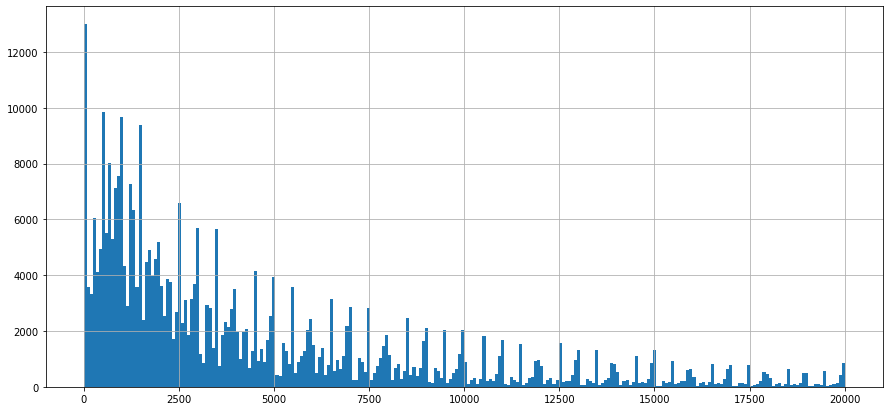

In [7]:
df['Price'].hist(bins=250, figsize=(15,7))

Исключим даныне из рассмотрения для которых цена указана как 0:

In [8]:
df = df.query('Price>0')

Мощность автомобиля не может быть равна нулю, поэтому такие нулевые признаки будем считать пропусками в значениях:

In [9]:
df.loc[df['Power']==0, 'Power'] = np.nan

<AxesSubplot:>

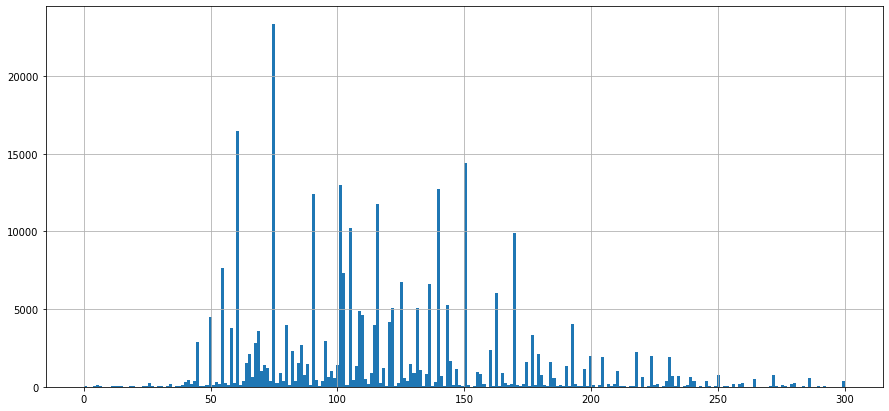

In [10]:
df["Power"].hist(range = [0,300], bins=250, figsize=(15,7))

In [11]:
power_quantile_1 = df["Power"].quantile(0.01)
power_quantile_1

45.0

In [12]:
power_quantile_99 = df['Power'].quantile(0.99)
power_quantile_99

306.0

In [13]:
df.loc[df['Power']<power_quantile_1, 'Power'] = np.nan
df.loc[df['Power']>power_quantile_99, 'Power'] = np.nan

В годе выпуска существуют выбросы значений, исключим такие данные из рассмотрения:

In [14]:
df['RegistrationYear'].value_counts().sort_index()

1000    31
1001     1
1039     1
1111     1
1234     4
        ..
8500     1
8888     1
9000     2
9450     1
9999    18
Name: RegistrationYear, Length: 140, dtype: int64

In [15]:
registration_year_quantile_1 = df['RegistrationYear'].quantile(0.01)
registration_year_quantile_1

1980.0

In [17]:
df.describe(include='object')

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
count,343597,309847,326242,326076,314138,343597,277731,343597,343597
unique,265135,8,2,250,7,40,2,109,174543
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 09:46:00
freq,7,89405,261373,28246,210765,74413,243682,13342,16


In [18]:
df[df['RegistrationYear']>2016].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90.0,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125.0,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80.0,golf,100000,1,petrol,volkswagen,NaN,2016-03-25 00:00:00,0,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90.0,punto,150000,11,gasoline,fiat,yes,2016-03-07 00:00:00,0,66115,2016-03-07 18:57:08
57,2016-03-10 20:53:19,2399,NaN,2018,manual,64.0,other,125000,3,NaN,seat,no,2016-03-10 00:00:00,0,33397,2016-03-25 10:17:37


Также исключим выбросы в цене автомобиля:

In [19]:
price_quantile_1 = df["Price"].quantile(0.01)
price_quantile_1

100.0

In [20]:
df = df.query('2016 >= RegistrationYear > @registration_year_quantile_1')
df = df.query('Price > @price_quantile_1').reset_index(drop=True)

In [21]:
df['RegistrationYear'].value_counts().sort_index()

1981      247
1982      299
1983      400
1984      382
1985      641
1986      492
1987      623
1988      892
1989     1215
1990     2352
1991     2566
1992     2805
1993     3174
1994     4513
1995     8560
1996    10170
1997    13731
1998    16920
1999    21780
2000    22496
2001    19550
2002    18666
2003    19450
2004    19300
2005    21341
2006    19639
2007    16975
2008    15220
2009    14372
2010    10656
2011     9812
2012     7105
2013     4077
2014     2494
2015     1161
2016     8764
Name: RegistrationYear, dtype: int64

Удалим лишние признаки:

In [22]:
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'PostalCode', 'RegistrationMonth'], axis=1)

Присвоим пропускам в категориальных признаках отдельный признак и обозначим как NaN:

In [23]:
values = {'VehicleType': 'NaN',
          'Gearbox': 'NaN',
          'Model': 'NaN',
          'FuelType': 'NaN',
          'Brand': 'NaN',
          'NotRepaired': 'NaN'}
df = df.fillna(value=values)

Количество пройденных машиной километров можно считать категориальным признаком так как количество вариантов не велико:

In [24]:
len(df['Kilometer'].unique())

13

Предобработка данных закончена, убраны лишние признаки исключены аномалии и выбросы из данных.

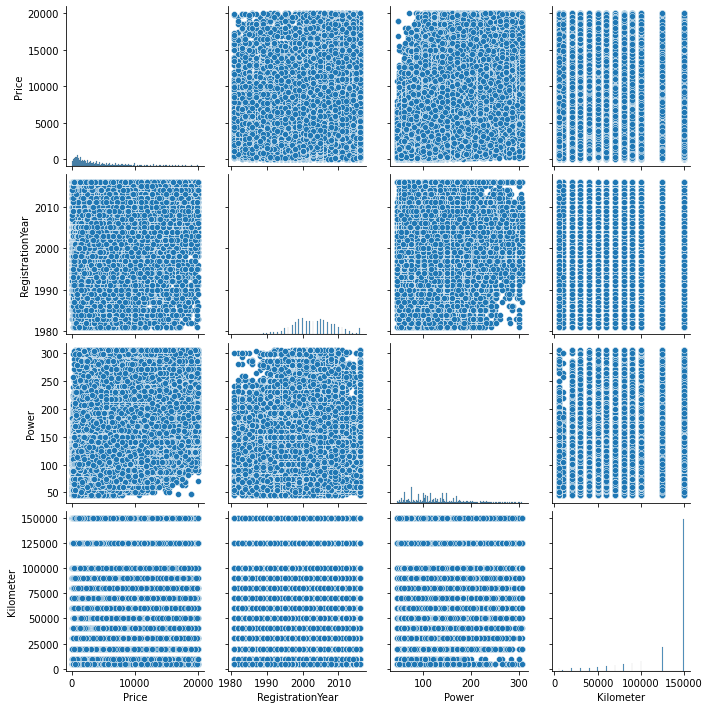

In [25]:
sns.pairplot(df)

In [26]:
df.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.550106,0.506623,-0.367190
RegistrationYear,0.550106,1.000000,0.135390,-0.336273
Power,0.506623,0.135390,1.000000,0.100142
Kilometer,-0.367190,-0.336273,0.100142,1.000000


Сильно коррелирующих между собой признаков не обнаружено.

In [27]:
df = df.drop_duplicates().reset_index(drop=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280776 entries, 0 to 280775
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             280776 non-null  int64  
 1   VehicleType       280776 non-null  object 
 2   RegistrationYear  280776 non-null  int64  
 3   Gearbox           280776 non-null  object 
 4   Power             249567 non-null  float64
 5   Model             280776 non-null  object 
 6   Kilometer         280776 non-null  int64  
 7   FuelType          280776 non-null  object 
 8   Brand             280776 non-null  object 
 9   NotRepaired       280776 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 21.4+ MB


In [29]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,NaN,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190.0,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no


In [30]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,280776.000000,280776.000000,249567.000000,280776.000000
mean,4701.355276,2003.037015,120.642741,127749.932330
std,4579.803068,6.053972,49.200380,37504.025178
min,101.000000,1981.000000,45.000000,5000.000000
25%,1250.000000,1999.000000,80.000000,125000.000000
50%,2999.000000,2003.000000,115.000000,150000.000000
75%,6800.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,306.000000,150000.000000


## Обучение моделей

### CatBoost

In [31]:
features_train, features_valid, target_train, target_valid = train_test_split(df.drop('Price', axis=1), df.Price,
                                                                              test_size=0.25,
                                                                              random_state=1,
                                                                              stratify = df['RegistrationYear'])

In [32]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'Kilometer']

In [33]:
model = CatBoostRegressor()
params = {
    'max_depth' : [2, 10],
    'random_seed' : [12345],
    'learning_rate' : [0.5],
    'logging_level' : ['Silent']
}
grid = GridSearchCV(estimator=model,
                    param_grid=params, 
                               cv=2,
                               scoring='neg_mean_squared_error')
grid.fit(features_train, target_train,
         cat_features=cat_features,
         plot=False)

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x7ffadd4617c0>,
             param_grid={'learning_rate': [0.5], 'logging_level': ['Silent'],
                         'max_depth': [2, 10], 'random_seed': [12345]},
             scoring='neg_mean_squared_error')

In [34]:
print('Лучшие гиперпараметры: ', grid.best_params_)

Лучшие гиперпараметры:  {'learning_rate': 0.5, 'logging_level': 'Silent', 'max_depth': 10, 'random_seed': 12345}


In [35]:
print('RMSE: {:.2f}'.format((-grid.best_score_)**0.5))

RMSE: 1711.75


Обучим модель с подобранными гиперпараметрами:

In [36]:
model = CatBoostRegressor(iterations=1000,
                          max_depth = 10,
                          random_seed=12345,
                          learning_rate=0.25,
                          logging_level='Silent',
                          od_type='Iter',
                          od_wait=20)

In [37]:
%%time
model.fit(features_train,
          target_train,
          cat_features=cat_features,
          eval_set=(features_valid, target_valid),
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 6min 3s, sys: 2.58 s, total: 6min 5s
Wall time: 6min 8s


In [38]:
%%time
pred_valid = model.predict(features_valid)

CPU times: user 1.07 s, sys: 8 ms, total: 1.08 s
Wall time: 1.08 s


In [39]:
catboost_rmse = (mean_squared_error(pred_valid, target_valid))**0.5
catboost_rmse

1570.2776332383096

### LightGBM

In [40]:
categorical_feature = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'Kilometer']

Закодируем катигориальные признаки:

In [41]:
label_encode = LabelEncoder()
for i in categorical_feature:
    label_encode.fit(df[i].astype('str'))
    df[i] = label_encode.transform(df[i].astype('str'))

In [42]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,0,1993,2,NaN,117,3,7,38,0
1,18300,3,2011,2,190.0,26,2,3,1,2
2,9800,7,2004,1,163.0,118,2,3,14,0
3,1500,6,2001,2,75.0,117,3,7,38,1
4,3600,6,2008,2,69.0,102,12,3,31,1


In [43]:
for i in categorical_feature:
    df[i] = df[i].astype('category')

In [44]:
features_train, features_valid, target_train, target_valid = train_test_split(df.drop('Price', axis=1), df.Price,
                                                                              test_size=0.25,
                                                                              random_state=1,
                                                                              stratify = df['RegistrationYear'])

Найдем лучшие гиперпараметры модели:

In [51]:
%%time
model = LGBMRegressor()
params = {
    'boosting_type' : ['gbdt'],
    'max_depth' : [2, 10],
    'verbose' : [0],
    'random_state' : [12345],
    'force_col_wise': [True],
    'num_leaves' : [70]}
grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    cv=2,
                    scoring='neg_mean_squared_error')
grid.fit(features_train, target_train,
         categorical_feature=categorical_feature)

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


CPU times: user 48.9 s, sys: 243 ms, total: 49.1 s
Wall time: 49.6 s


GridSearchCV(cv=2, estimator=LGBMRegressor(),
             param_grid={'boosting_type': ['gbdt'], 'force_col_wise': [True],
                         'max_depth': [2, 10], 'num_leaves': [70],
                         'random_state': [12345], 'verbose': [0]},
             scoring='neg_mean_squared_error')

In [52]:
print('Лучшие гиперпараметры: ', grid.best_params_)

Лучшие гиперпараметры:  {'boosting_type': 'gbdt', 'force_col_wise': True, 'max_depth': 10, 'num_leaves': 70, 'random_state': 12345, 'verbose': 0}


In [53]:
print('RMSE: {:.2f}'.format((-grid.best_score_) ** 0.5))

RMSE: 1619.42


Обучим модель с лучшими гиперпараметрами:

In [54]:
%%time
params = {
    'boosting_type' : ['gbdt'],
    'max_depth' : [10],
    'verbose' : [0],
    'random_state' : [12345],
    'force_col_wise': [True],
    'num_leaves' : [70]}
model_lgb = LGBMRegressor(**params)
model_lgb.fit(features_train, target_train,
              eval_set=(features_valid, target_valid),
              verbose=0,
              eval_metric='root_mean_squared_error')

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


CPU times: user 13.2 s, sys: 95.4 ms, total: 13.3 s
Wall time: 13.4 s


LGBMRegressor(boosting_type=['gbdt'], force_col_wise=[True], max_depth=[10],
              num_leaves=[70], random_state=[12345], verbose=[0])

In [55]:
%%time
predict = model_lgb.predict(features_valid)

CPU times: user 1.02 s, sys: 0 ns, total: 1.02 s
Wall time: 1.09 s


In [56]:
lgbm_rmse = (mean_squared_error(predict, target_valid))**0.5
lgbm_rmse

1592.1982632407576

## Анализ моделей

CatBoost:
- значение метрики RMSE равно 1570.2;
- время обучения модели 6 минут 8 секунд;
- время предсказания 1.08 секунд

LightGBM:
- значение метрики RMSE равно 1592.19;
- время обучения модели 13.4 секунд;
- время предсказания 1.09 секунд

Вывод: метрика RMSE получилась меньше при использовании модели CatBoost, время обучения модели быстрее всего при использовании LightGBM, а время предсказания одинаково.